# Diagnostic Action Sequence Prediction (DAS) Model

This model uses a given initial diagnostic action to predict the most likely next action. It does not consider the fault or claim history of a vehicle.

In [11]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, pad_sequences
from keras.metrics import AUC, Precision, Recall
from keras.utils import to_categorical
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

MODEL_NAME = 'das'

In [12]:
# Load prepared data
df = pd.read_csv('./data_out/prepared_chunks_data.csv', low_memory=False)

In [13]:
# Encode target 'otxsequence' feature
label_encoder = LabelEncoder()
df.loc[:, 'otxsequence'] = label_encoder.fit_transform(df['otxsequence'])
all_classes = to_categorical(label_encoder.transform(label_encoder.classes_))
num_classes = all_classes.shape[1]

/var/folders/jr/q6r6st3d7577lv0703lr57mm0000gn/T/ipykernel_21491/990468071.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'otxsequence'] = label_encoder.fit_transform(df['otxsequence'])


In [14]:
# Sort values by 'consultationid' to ensure actions for the same consultation are together
df.sort_values(['consultationid', 'timestamp'], inplace=True)
df['otxsequence'] = df['otxsequence'].astype(str)

# Group by consultationid and join the activities
grouped = df.groupby('consultationid')['otxsequence'].agg(lambda x: list(set(x))).reset_index()
# Filter out all the groups with less than 2 actions
grouped = grouped[grouped['otxsequence'].apply(len) > 1]
grouped = grouped.drop_duplicates('consultationid')
sequences = grouped['otxsequence'].apply(lambda x: list(map(int, x)))

In [15]:
input_length = 1  # Single action will be used to predict the next seq_length actions
seq_length = 1 # Single action will be predicted

X, y = [], []
for seq in sequences:
    for i in range(0, len(seq)-1):
        X.append([seq[i]])
        y.append(seq[i+1])

# Pad sequences to ensure consistent length
X = pad_sequences(X, maxlen=input_length, padding='post')
y_onehot = to_categorical(y, num_classes=num_classes)

In [16]:
# Train-test split
train_input, test_input, train_out, test_out = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

2023-08-06 18:29:10.554898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 18:29:10.558636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 18:29:10.560217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

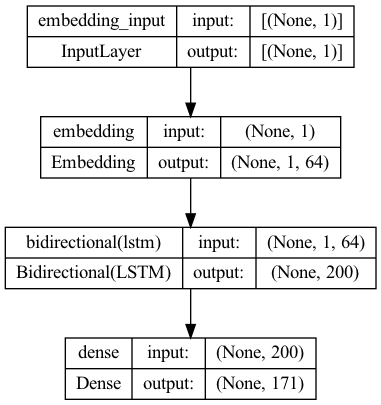

In [17]:
num_activities = df['otxsequence'].nunique()

model = Sequential()
model.add(Embedding(input_dim=num_activities+1, output_dim=64, input_length=input_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(num_activities, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',
                                                                          AUC(name='auc', multi_label=True),
                                                                          Precision(name='precision'),
                                                                          Recall(name='recall')])
plot_model(model, to_file=f'./out/models/{MODEL_NAME}/{MODEL_NAME}_layers.png', show_shapes=True, show_layer_names=True)

In [25]:
%%time
early_stopping_monitor = EarlyStopping(
    monitor='accuracy',
    min_delta=0.001,  # minimum change to qualify as an improvement
    patience=10,  # number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_input,
    train_out,
    epochs=50,
    batch_size=32,
    validation_data=(test_input, test_out),
    callbacks=[early_stopping_monitor])

Epoch 1/50
44/44 [==============================] - 0s 10ms/step - loss: 1.1607 - accuracy: 0.6273 - auc: 0.4892 - precision: 0.7700 - recall: 0.5029 - val_loss: 1.9282 - val_accuracy: 0.5914 - val_auc: 0.2437 - val_precision: 0.7210 - val_recall: 0.4800
Epoch 2/50
44/44 [==============================] - 1s 12ms/step - loss: 1.1532 - accuracy: 0.6366 - auc: 0.4889 - precision: 0.7505 - recall: 0.5186 - val_loss: 1.9398 - val_accuracy: 0.6000 - val_auc: 0.2436 - val_precision: 0.7371 - val_recall: 0.4886
Epoch 3/50
44/44 [==============================] - 1s 11ms/step - loss: 1.1467 - accuracy: 0.6295 - auc: 0.4899 - precision: 0.7628 - recall: 0.5222 - val_loss: 1.9330 - val_accuracy: 0.5943 - val_auc: 0.2439 - val_precision: 0.7359 - val_recall: 0.4857
Epoch 4/50
44/44 [==============================] - 1s 13ms/step - loss: 1.1439 - accuracy: 0.6352 - auc: 0.4901 - precision: 0.7784 - recall: 0.5050 - val_loss: 1.9477 - val_accuracy: 0.6029 - val_auc: 0.2436 - val_precision: 0.7208 -

In [23]:
from sklearn.metrics import ndcg_score
from model_utils import save_plot_accuracy_loss, save_plot_precision_recall, save_plot_auc

# Evaluate the performance of the model on the test data
loss, accuracy, auc, precision, recall = model.evaluate(test_input, test_out)
f1 = 2 * (recall * precision / (recall + precision))
y_pred = model.predict(test_input)
ndcg = ndcg_score(test_out, y_pred)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC-ROC: {auc}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1: {f1}")
print(f"Test NDCG: {ndcg}")

11/11 [==============================] - 0s 3ms/step
Test Loss: 1.913572072982788
Test Accuracy: 0.6028571724891663
Test AUC-ROC: 0.24368000030517578
Test Precision: 0.7342342138290405
Test Recall: 0.4657142758369446
Test F1: 0.5699300563864745
Test NDCG: 0.7815278840096962


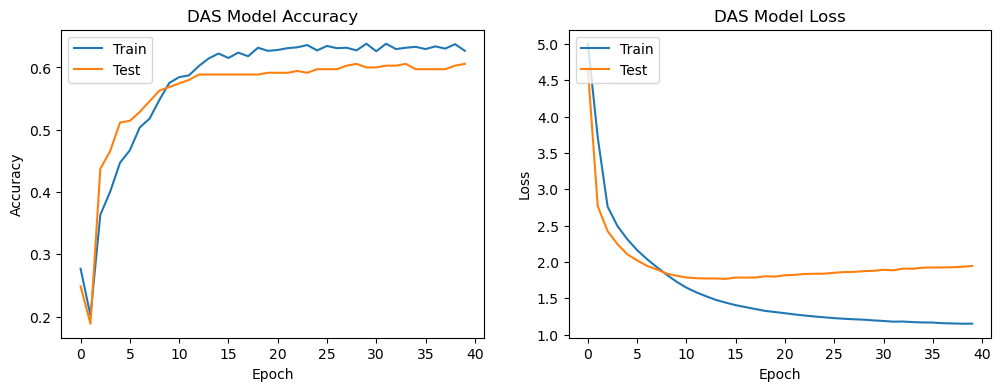

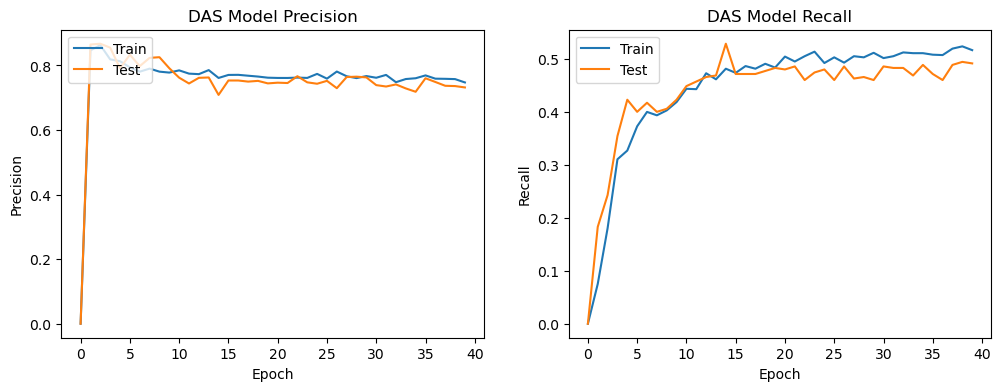

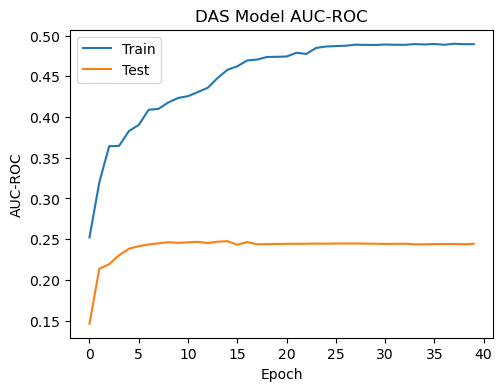

In [21]:
save_plot_accuracy_loss(history, 'DAS', f'{MODEL_NAME}/{MODEL_NAME}_training')
save_plot_precision_recall(history, 'DAS', f'{MODEL_NAME}/{MODEL_NAME}_training2')
save_plot_auc(history, 'DAS', f'{MODEL_NAME}/{MODEL_NAME}_training3')

In [20]:
# Save the trained model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model.save(f'./out/models/{MODEL_NAME}_{timestamp}.keras')

In [ ]:
# Generate Recommendations

# print(f'predicted_actions_uq {predicted_actions_uq}')
# tokenized_input = tokenizer.texts_to_sequences([predicted_actions_uq])
# # Convert to the correct input shape
# das_input = np.array(tokenized_input).reshape((1, -1))
# print(f'das_input {das_input}')
#
# prediction = model.predict(das_input)
# predicted_sequence_indices = np.argmax(final_prediction, axis=-1)
#
# print(f'Predicted action: {predicted_actions}')